In [ ]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re
import string
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/IUI_projekt/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/IUI_projekt/test.csv')
labels = pd.read_csv('/content/drive/MyDrive/IUI_projekt/test_labels.csv')

In [ ]:
# sprawdzenie czy są dane puste 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
id              0
comment_text    0
dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\<.*?\>', '', text)
    text = re.sub('\(.*?\)', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train_data['clean_text'] = train_data['comment_text'].apply(str).apply(lambda x: clean_text(x))
test_data['clean_text'] = test_data['comment_text'].apply(str).apply(lambda x: clean_text(x))

In [ ]:
x_train, x_test_withlab, y_train, y_test_withlab = train_test_split(train_data.comment_text.values, train_data.toxic.values,  
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
# x_valid, x_test_withlab, y_valid, y_test_withlab = train_test_split(x_valid, y_valid, test_size=0.5, random_state=32, shuffle=True)

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 192

token.fit_on_texts(list(x_train)) #+ list(x_valid))
xtrain_seq = token.texts_to_sequences(x_train)
# xvalid_seq = token.texts_to_sequences(x_valid)
xtest_seq = token.texts_to_sequences(x_test_withlab)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
# xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

## **Simple RNN model - without transfer learning**

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300, input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 192, 300)          54959400  
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 100)               40100     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 54,999,601
Trainable params: 54,999,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history = model.fit(xtrain_pad, y_train, epochs=3, batch_size=16, steps_per_epoch=1000, validation_split=0.2)

Epoch 1/3
1000/1000 [==============================] - 631s 630ms/step - loss: 0.3948 - accuracy: 0.8794 - val_loss: 0.3168 - val_accuracy: 0.9033
Epoch 2/3
1000/1000 [==============================] - 627s 627ms/step - loss: 0.3194 - accuracy: 0.9018 - val_loss: 0.3148 - val_accuracy: 0.9034
Epoch 3/3
1000/1000 [==============================] - 623s 623ms/step - loss: 0.3292 - accuracy: 0.8929 - val_loss: 0.3224 - val_accuracy: 0.9035


In [ ]:
y_pred = model.predict(xtest_pad)

In [ ]:
threshold = 0.8
prediction_list = []
for prediction in y_pred: 
  if prediction[0] >= threshold: 
    prediction_list.append(1)
  else: 
    prediction_list.append(0)

In [ ]:
accuracy = accuracy_score(y_test_withlab, prediction_list)*100
conf_matrix = confusion_matrix(y_test_withlab, prediction_list)
report = classification_report(y_test_withlab, prediction_list)

In [ ]:
print("Dokładność jest równa: " + str(round(accuracy, 2)) + "%")
print(conf_matrix)
print(report)

Dokładność jest równa: 90.54%
[[14446     0]
 [ 1509     3]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     14446
           1       1.00      0.00      0.00      1512

    accuracy                           0.91     15958
   macro avg       0.95      0.50      0.48     15958
weighted avg       0.91      0.91      0.86     15958



In [ ]:
model_accuracy = model_history.history["accuracy"]
model_loss = model_history.history["loss"]
model_val_accuracy = model_history.history["val_accuracy"]
model_val_loss = model_history.history["val_loss"]

In [ ]:
print("Dokładność modelu: " + str(model_accuracy))
print("Wartość loss dla modelu: " + str(model_loss))
print("Dokładność modelu dla danych walidacyjnych: " + str(model_val_accuracy))
print("Wartość val_loss dla modelu: " + str(model_val_loss))

Dokładność modelu: [0.8793749809265137, 0.9017500281333923, 0.8928750157356262]
Wartość loss dla modelu: [0.39480656385421753, 0.31941092014312744, 0.3292350471019745]
Dokładność modelu dla danych walidacyjnych: [0.9032978415489197, 0.9033761620521545, 0.9034544825553894]
Wartość val_loss dla modelu: [0.3168138563632965, 0.314765602350235, 0.3224342167377472]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



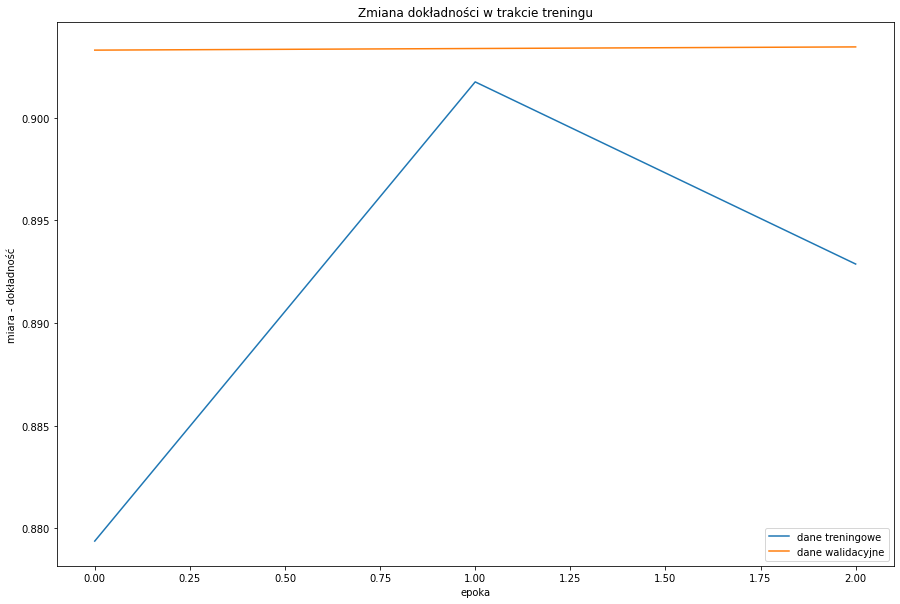

In [ ]:
figure = plt.figure(figsize=(15,10))
plt.title("Zmiana dokładności w trakcie treningu")
figure_acc = figure.add_subplot(1,1,1)
figure_acc.set_xlabel('epoka')
figure_acc.set_ylabel('miara - dokładność')
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['dane treningowe', 'dane walidacyjne'])
plt.show()

In [ ]:
figure = plt.figure(figsize=(15,10))
plt.title("Zmiana parametru loss w trakcie treningu")
figure_acc = figure.add_subplot(1,1,1)
figure_acc.set_xlabel('epoka')
figure_acc.set_ylabel('miara - loss')
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['dane treningowe', 'dane walidacyjne'])

plt.show()

## **LSTM model - without transfer learningu** 


In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))

model_LSTM.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.compile(Adam(lr=(1e-5)), loss='binary_crossentropy', metrics=['accuracy'])   
model_LSTM.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 192, 300)          54959400  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 55,119,901
Trainable params: 55,119,901
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
model_LSTM_history = model_LSTM.fit(xtrain_pad, y_train, epochs=3, batch_size=16, steps_per_epoch=1000, validation_split=0.2)

Epoch 1/3
1000/1000 [==============================] - 1153s 1s/step - loss: 0.4941 - accuracy: 0.8764 - val_loss: 0.3204 - val_accuracy: 0.9036
Epoch 2/3
1000/1000 [==============================] - 1139s 1s/step - loss: 0.3028 - accuracy: 0.9086 - val_loss: 0.3078 - val_accuracy: 0.9037
Epoch 3/3
1000/1000 [==============================] - 1168s 1s/step - loss: 0.3004 - accuracy: 0.9040 - val_loss: 0.2953 - val_accuracy: 0.9038


In [ ]:
y_pred_LSTM = model.predict(xtest_pad)

In [ ]:
threshold = 0.8
prediction_list = []
for prediction in y_pred_LSTM: 
  if prediction[0] >= threshold: 
    prediction_list.append(1)
  else: 
    prediction_list.append(0)

In [ ]:
accuracy = accuracy_score(y_test_withlab, prediction_list)*100
conf_matrix = confusion_matrix(y_test_withlab, prediction_list)
report = classification_report(y_test_withlab, prediction_list)

In [ ]:
print("Dokładność jest równa: " + str(round(accuracy, 2)) + "%")
print(conf_matrix)
print(report)

Dokładność jest równa: 90.44%
[[28859     0]
 [ 3050     6]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     28859
           1       1.00      0.00      0.00      3056

    accuracy                           0.90     31915
   macro avg       0.95      0.50      0.48     31915
weighted avg       0.91      0.90      0.86     31915



In [ ]:
model_accuracy = model_LSTM_history.history["accuracy"]
model_loss = model_LSTM_history.history["loss"]
model_val_accuracy = model_LSTM_history.history["val_accuracy"]
model_val_loss = model_LSTM_history.history["val_loss"]

In [ ]:
print("Dokładność modelu: " + str(model_accuracy))
print("Wartość loss dla modelu: " + str(model_loss))
print("Dokładność modelu dla danych walidacyjnych: " + str(model_val_accuracy))
print("Wartość val_loss dla modelu: " + str(model_val_loss))

Dokładność modelu: [0.8764374852180481, 0.9085624814033508, 0.9039999842643738]
Wartość loss dla modelu: [0.49410274624824524, 0.302786648273468, 0.30043458938598633]
Dokładność modelu dla danych walidacyjnych: [0.9036111831665039, 0.9036503434181213, 0.9038069844245911]
Wartość val_loss dla modelu: [0.3204306662082672, 0.3077719211578369, 0.2952583432197571]


In [ ]:
figure = plt.figure(figsize=(15,10))
plt.title("Zmiana dokładności w trakcie treningu")
figure_acc = figure.add_subplot(1,1,1)
figure_acc.set_xlabel('epoka')
figure_acc.set_ylabel('miara - dokładność')
plt.plot(model_LSTM_history.history['accuracy'])
plt.plot(model_LSTM_history.history['val_accuracy'])
plt.legend(['dane treningowe', 'dane walidacyjne'])
plt.show()

In [ ]:
figure = plt.figure(figsize=(15,10))
plt.title("Zmiana parametru loss w trakcie treningu")
figure_acc = figure.add_subplot(1,1,1)
figure_acc.set_xlabel('epoka')
figure_acc.set_ylabel('miara - loss')
plt.plot(model_LSTM_history.history['loss'])
plt.plot(model_LSTM_history.history['val_loss'])
plt.legend(['dane treningowe', 'dane walidacyjne'])

plt.show()